##unzip Dataset

In [1]:
!unzip "/content/Dataset.zip"

Archive:  /content/Dataset.zip
   creating: Dataset/
   creating: Dataset/images/
  inflating: Dataset/images/IMG-1.jpg  
  inflating: Dataset/images/IMG-10.jpg  
  inflating: Dataset/images/IMG-100.jpg  
  inflating: Dataset/images/IMG-101.jpg  
  inflating: Dataset/images/IMG-102.jpg  
  inflating: Dataset/images/IMG-103.jpg  
  inflating: Dataset/images/IMG-104.jpg  
  inflating: Dataset/images/IMG-105.jpg  
  inflating: Dataset/images/IMG-106.jpg  
  inflating: Dataset/images/IMG-107.jpg  
  inflating: Dataset/images/IMG-108.jpg  
  inflating: Dataset/images/IMG-109.jpg  
  inflating: Dataset/images/IMG-11.jpg  
  inflating: Dataset/images/IMG-110.jpg  
  inflating: Dataset/images/IMG-111.jpg  
  inflating: Dataset/images/IMG-112.jpg  
  inflating: Dataset/images/IMG-113.jpg  
  inflating: Dataset/images/IMG-114.jpg  
  inflating: Dataset/images/IMG-115.jpg  
  inflating: Dataset/images/IMG-116.jpg  
  inflating: Dataset/images/IMG-117.jpg  
  inflating: Dataset/images/IMG-118.jpg 

##Custom Dataset Preparation

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class CustomSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None):
        """
        Args:
            images_dir (str): Path to the directory with input images.
            masks_dir (str): Path to the directory with segmentation masks.
            transform (callable, optional): Optional transform to apply to the images.
            target_transform (callable, optional): Optional transform to apply to the masks.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask




dataset = CustomSegmentationDataset(
    images_dir="/content/Dataset/images",
    masks_dir="/content/Dataset/mask",

)


##1.Split the Dataset
## 2.Normalization and augmentation

In [ ]:
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(513, scale=(0.5, 2.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((513, 513)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((513, 513)),
    transforms.ToTensor()
])

full_dataset = CustomSegmentationDataset(
    images_dir="/content/Dataset/images",
    masks_dir="/content/Dataset/mask"
)

dataset_size = len(full_dataset)
train_size = round(0.8 * dataset_size)
val_size = round(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

#applying transformations to each dataset split
train_dataset.dataset = CustomSegmentationDataset(
    images_dir="/content/Dataset/images",
    masks_dir="/content/Dataset/mask",
    transform=train_transform,
    target_transform=target_transform
)

val_dataset.dataset = CustomSegmentationDataset(
    images_dir="/content/Dataset/images",
    masks_dir="/content/Dataset/mask",
    transform=val_test_transform,
    target_transform=target_transform
)

test_dataset.dataset = CustomSegmentationDataset(
    images_dir="/content/Dataset/images",
    masks_dir="/content/Dataset/mask",
    transform=val_test_transform,
    target_transform=target_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


##Load the Model and Changing the layer

In [ ]:
import torchvision.models.segmentation as models
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import torch.nn as nn

# Number of classes: 2 foreground classes + 1 background class
num_classes = 3

weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = models.deeplabv3_resnet50(weights=weights)

model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))

for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 220MB/s]


##Find the trainning and Validation Loss , Avg Loss

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss() 

def calculate_metrics(loader, model, criterion):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
      for images, masks in tqdm(loader):
          images, masks = images.to(device), masks.to(device)

          masks = masks.squeeze(1)

          outputs = model(images)['out']
          loss = criterion(outputs, masks.long())
          running_loss += loss.item() * images.size(0)





    avg_loss = running_loss / len(loader.dataset)

    return avg_loss

train_loss= calculate_metrics(train_loader, model, criterion)
val_loss = calculate_metrics(val_loader, model, criterion)

print("\n")
print(f"Training Loss: {train_loss:.4f}")
print("\n")
print(f"Validation Loss: {val_loss:.4f}")


100%|██████████| 3/3 [00:06<00:00,  2.33s/it]



Training Loss: 1.0559


Validation Loss: 1.0489


##Vizualization

Training Set:


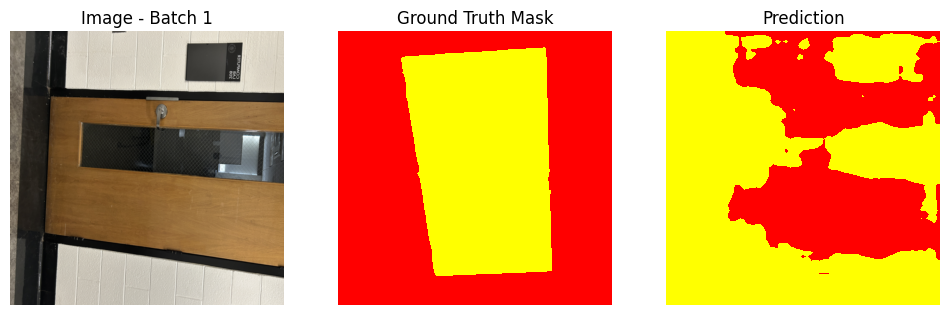

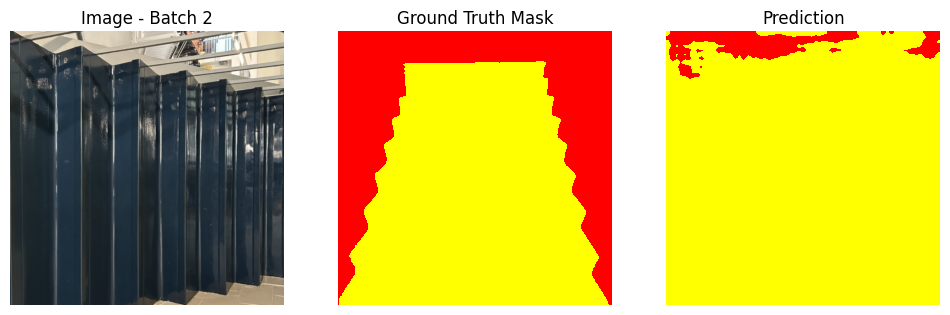

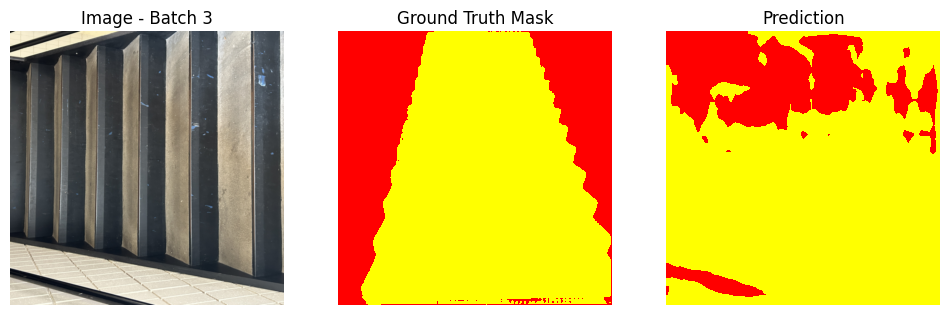

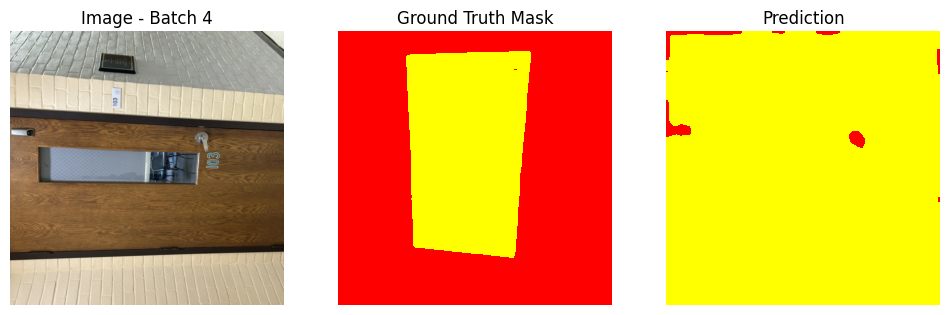

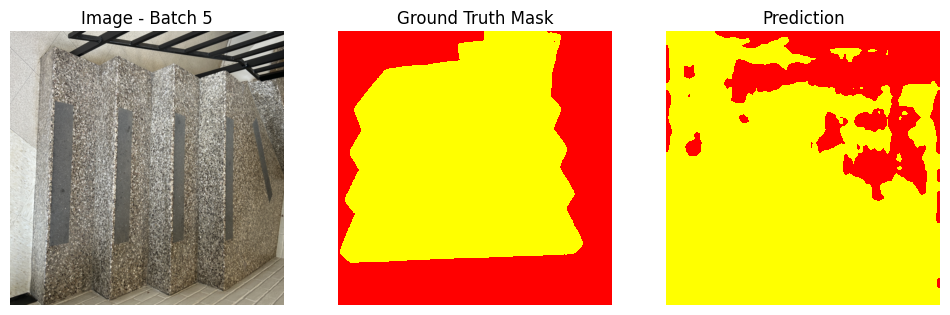

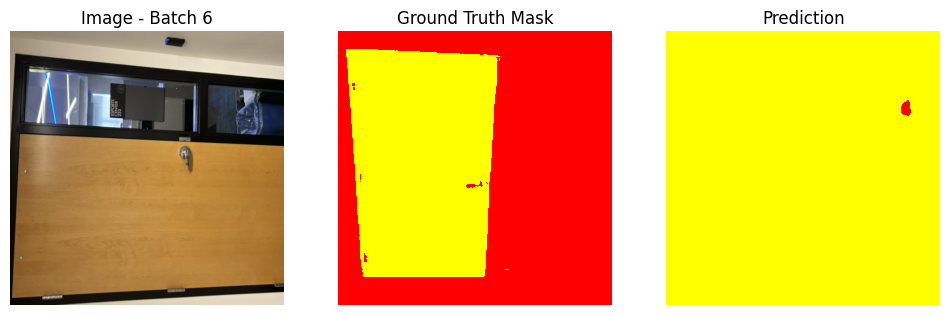

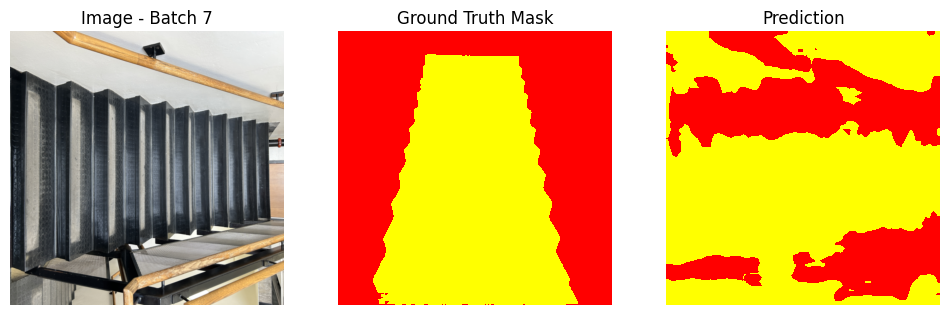

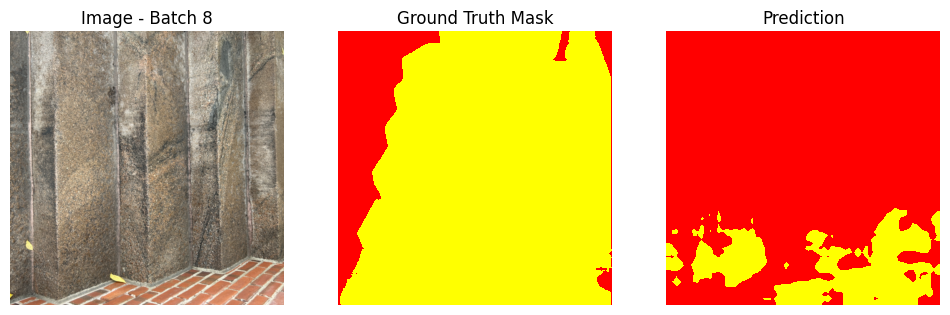

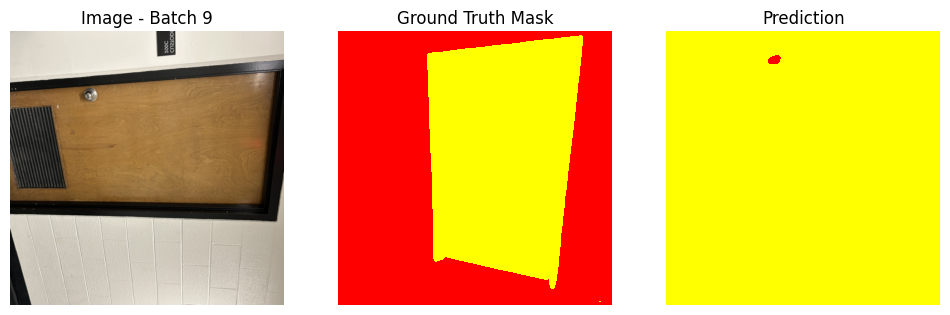

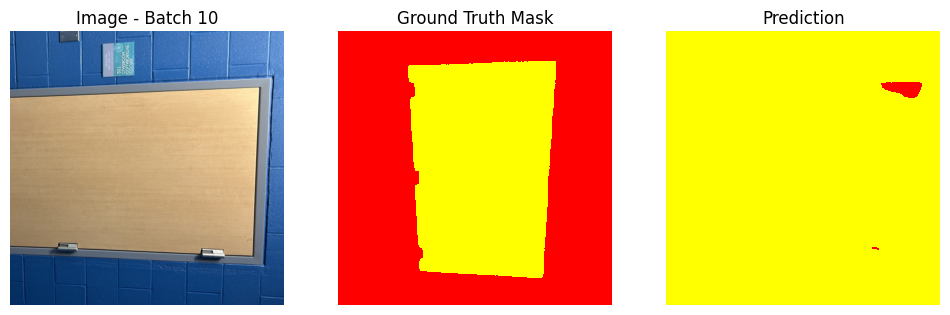

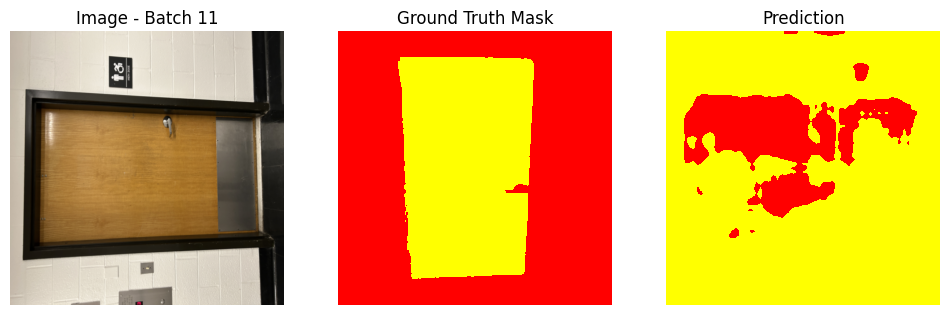

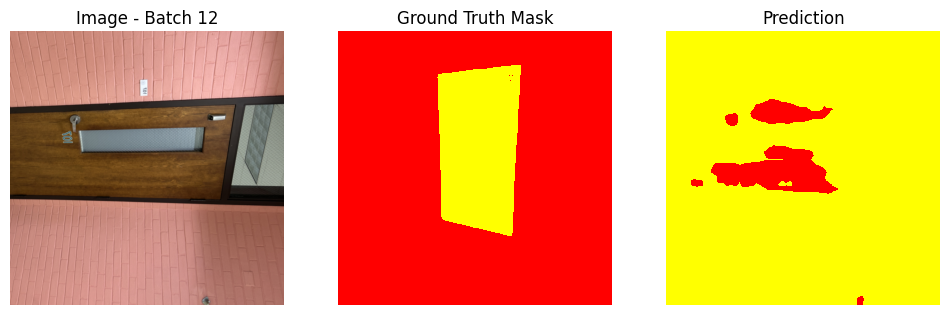

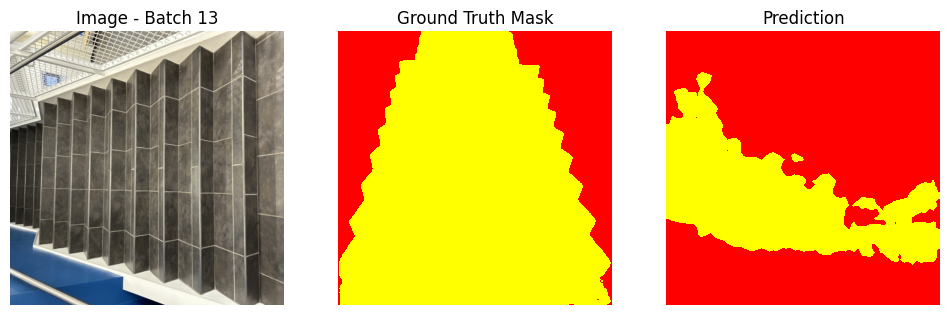

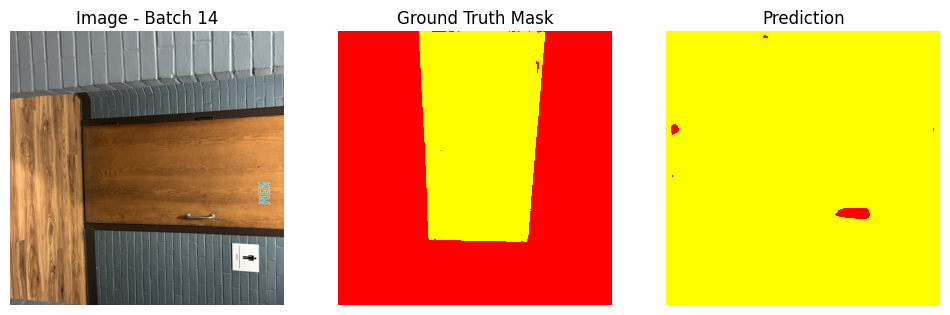

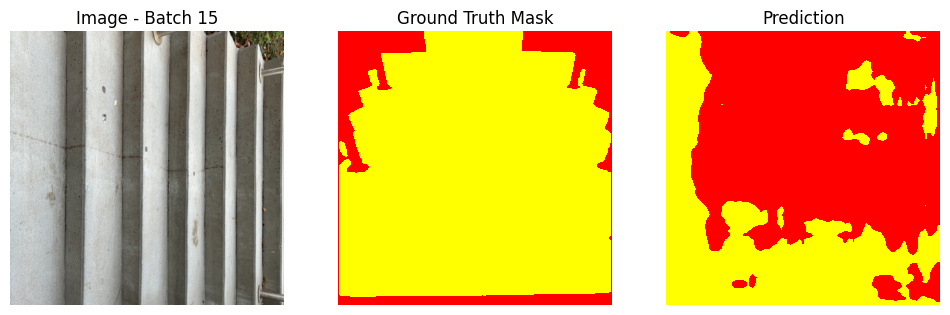

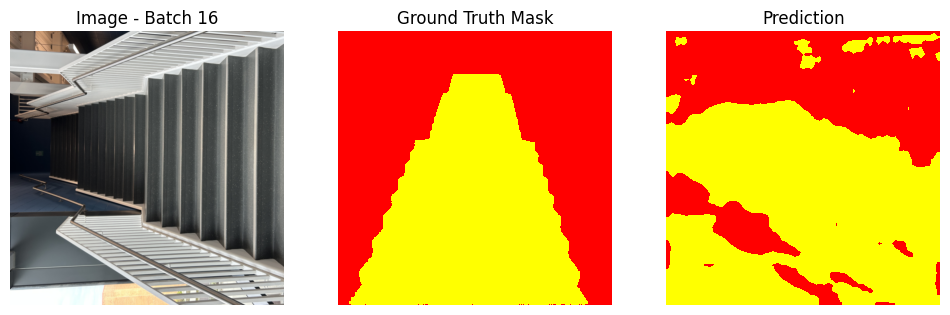

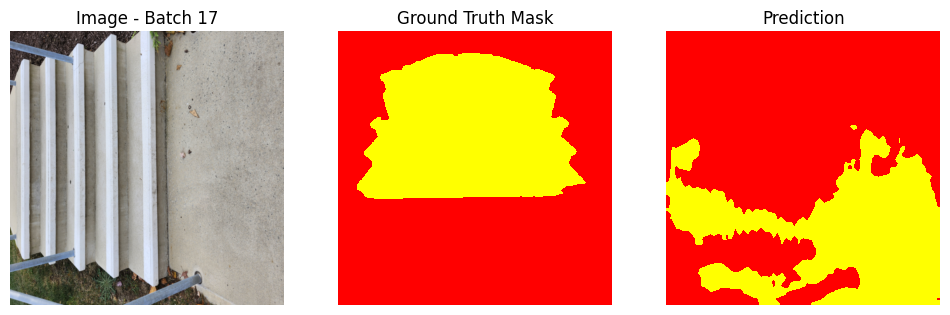

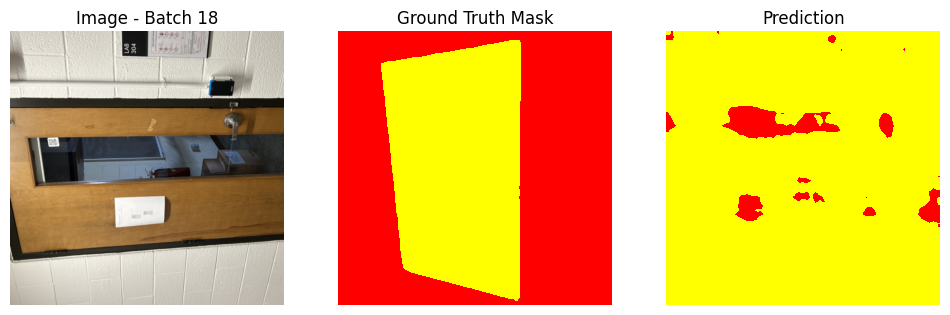

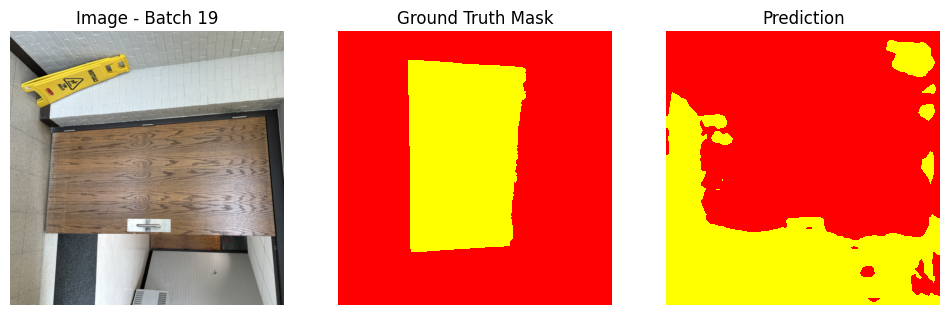

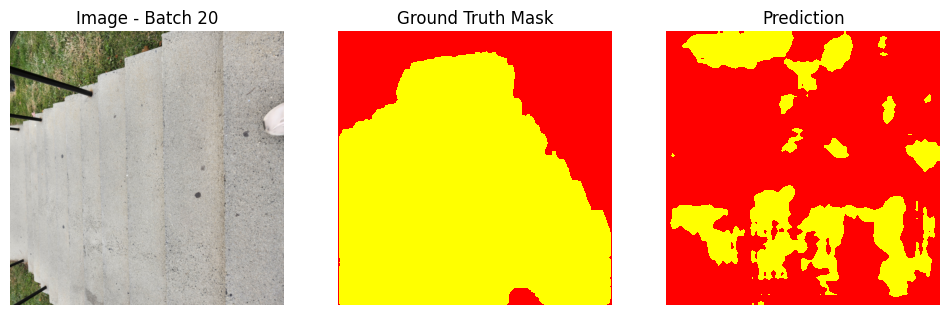

Validation Set:


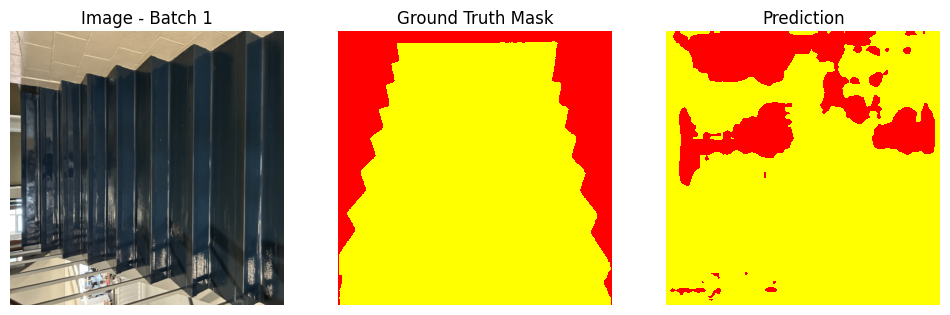

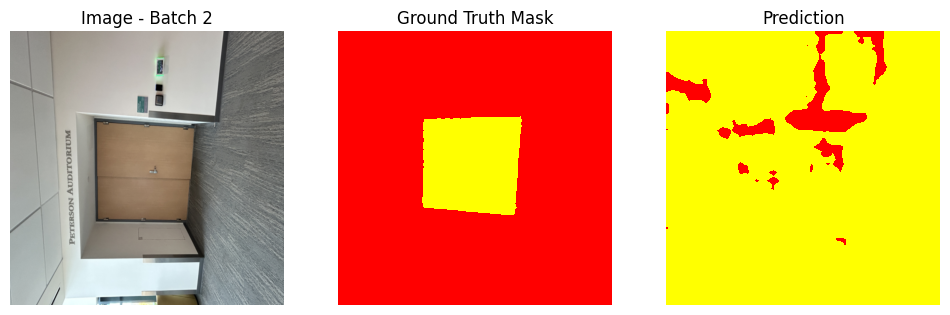

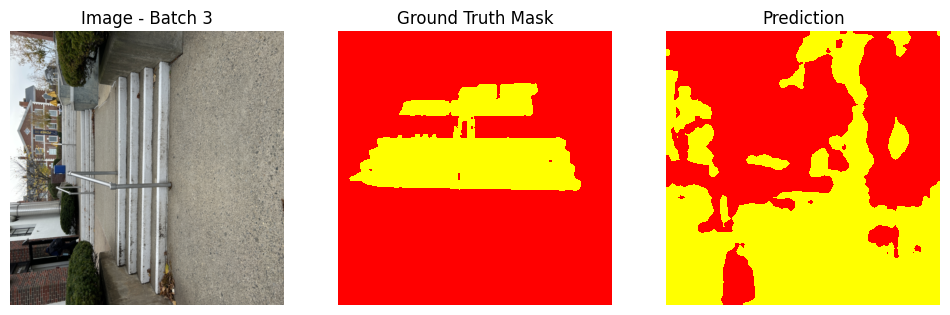

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

two_color_cmap = ListedColormap(["red", "yellow"])

def visualize_first_sample(loader, model, device):
    model.eval()

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loader):
            images, masks = images.to(device), masks.to(device)
            masks = masks.squeeze(1)

            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']

            _, predicted = torch.max(outputs, 1)

            image = images[0].cpu().numpy().transpose(1, 2, 0)
            mask = masks[0].cpu().numpy()
            prediction = predicted[0].cpu().numpy()

            image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
            image = np.clip(image, 0, 1)

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(image)
            axes[0].set_title(f"Image - Batch {batch_idx + 1}")
            axes[0].axis('off')

            axes[1].imshow(mask, cmap=two_color_cmap)
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis('off')

            axes[2].imshow(prediction, cmap=two_color_cmap)
            axes[2].set_title("Prediction")
            axes[2].axis('off')

            plt.show()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Training Set:")
visualize_first_sample(train_loader, model, device)

print("Validation Set:")
visualize_first_sample(val_loader, model, device)
